In [8]:
import numpy as np    
import matplotlib.pyplot as plt

In [108]:
class UpwindConvectionDiffusion1D:
    def __init__(self, alpha, beta, a, b, N, deltaT, T):
        self.alpha = alpha
        self.beta = beta
        self.a = a   
        self.b = b 
        self.N = N   
        self.deltaT = deltaT   
        self.T = T
        deltaX = (self.a - self.b)/self.N
        self.eA = (beta * deltaT) / deltaX**2 # beta
        self.eB = (alpha * deltaT) / deltaX # C
        
    def check_stability(self):
        print((self.eB**2-self.eB)/2)
        print(self.eA)
        print((1-self.eB)/2)
        return (self.eB**2-self.eB)/2 <= self.eA <= (1-self.eB)/2
    
    def solve(self, u0):
        B = self.eB
        A = self.eA
        nu = u0[:]
        nu[0] = 1
        nu[-1] = 0
        for j in range(1, N-1):
            if self.alpha > 0:
                nu[j] = (.5 *B + A)*u0[j-1] + (1-.5*B - 2*A)*u0[j] + A*u0[j+1]
            if self.alpha < 0:
                nu[j] =  (A - .5 *B)*u0[j-1] + (1+.5*B - 2*A)*u0[j] + A*u0[j+1]
        return nu    

In [109]:
class AnaliticSol:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = -beta
    def res(self, x, t):
        return 1/(2*np.selfqrt(np.pi*beta*t)*np.exp(-(x - alpha*t)**2/(4*beta*t)))

0.05700555555555555
0.010677777777777777
0.5516666666666666
False


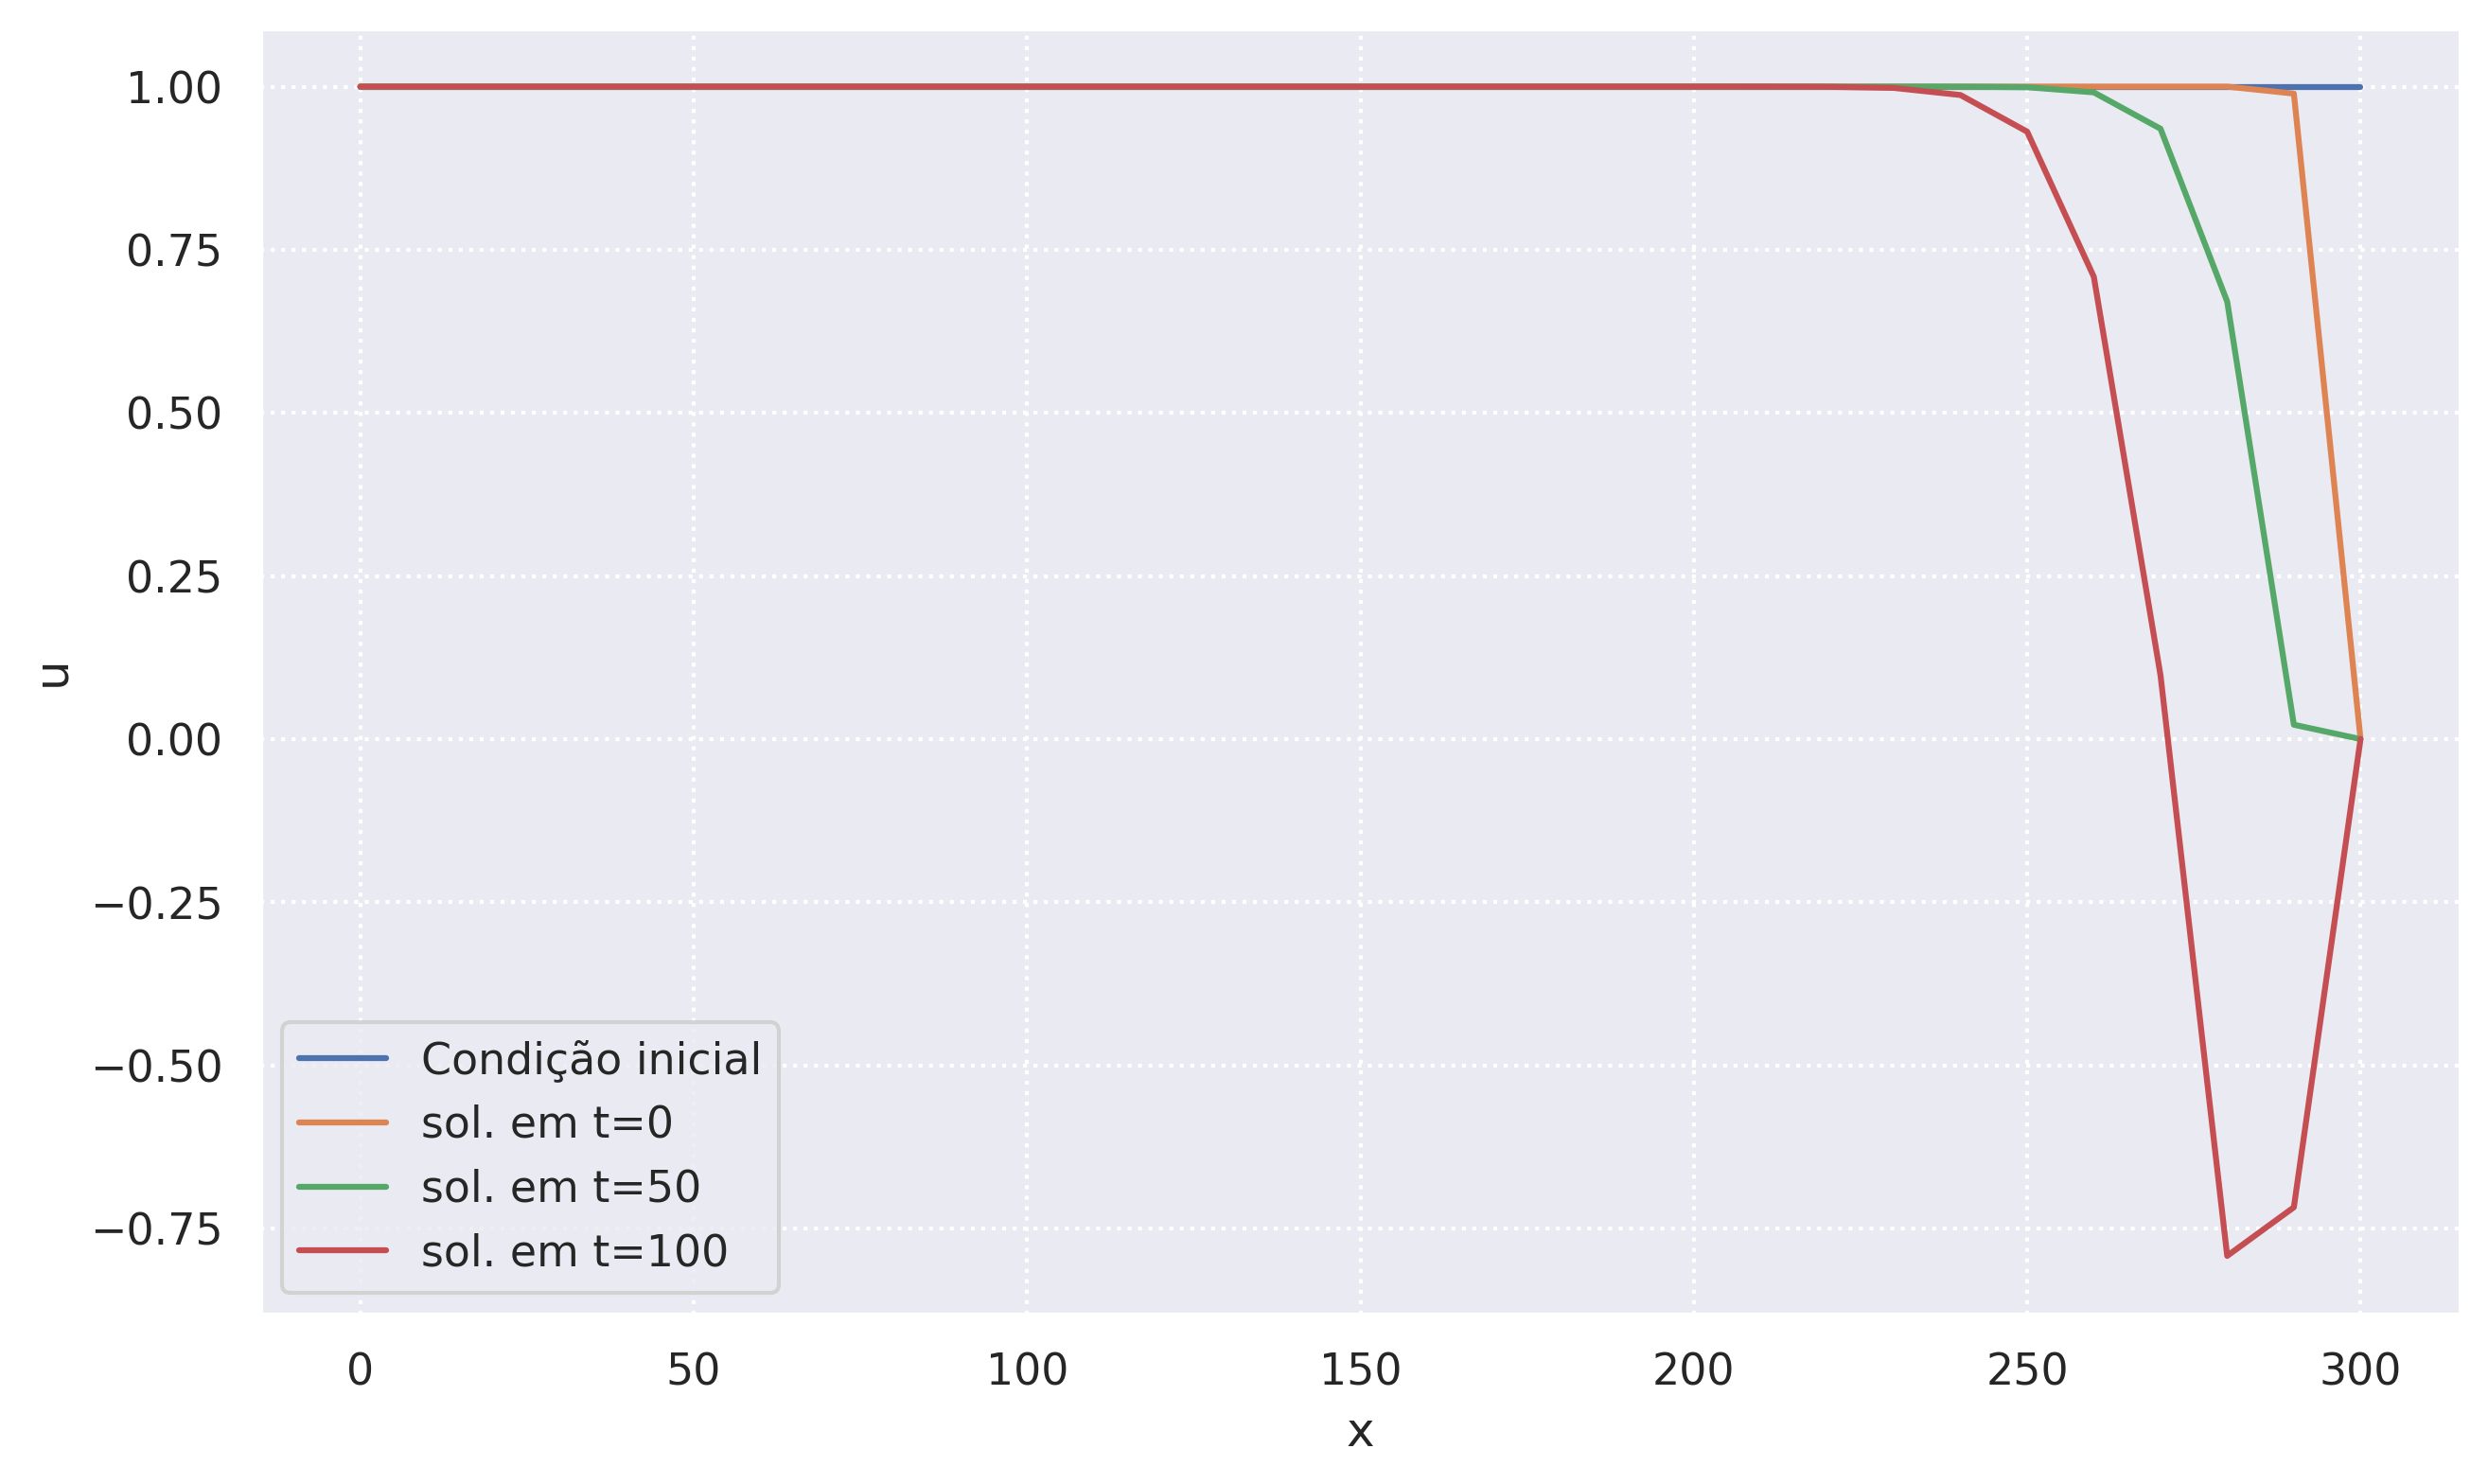

In [119]:
# constants 
# 112
# 128
# u(x,0) = f(x) = 0
# u(a,t) = u0
# u(b,t) = 0
a, b = 0, 300
alpha=1
beta=1
T=100
N=31
deltaT = 1

LCD1D = UpwindConvectionDiffusion1D(alpha, beta, a, b, N, deltaT, T)

# initial value
x=np.linspace(LCD1D.a,LCD1D.b,LCD1D.N).reshape(-1,1)
u0 = lambda x: x*0 + 1
u0 = u0(x)
# print(x)
# print(u0.shape)
#plot of initial value
plt.figure(figsize=(10,6), dpi=300)
plt.plot(x,u0,label="Condição inicial")
plt.ylabel('u')
plt.xlabel('x')
plt.legend()


print(LCD1D.check_stability())
for t in range(0,int(LCD1D.T/LCD1D.deltaT)):
    nu=LCD1D.solve(u0)
    u0=nu
    if t % 50 == 0:
        plt.plot(x,nu,label="sol. em t="+str(t))
        plt.legend()
        
plt.plot(x,nu,label="sol. em t="+str(T))
plt.legend()
plt.grid(linestyle='dotted')

In [ ]:
# https://core.ac.uk/download/pdf/42967717.pdf => pagina 3

In [127]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [128]:
t = np.linspace(0, LCD1D.T, LCD1D.T+1).reshape((-1, 1))
xx, tt = np.meshgrid(x, t)
x = xx.reshape((-1, 1))
t = tt.reshape((-1, 1))

In [166]:
def init_random_params(scale, layer_sizes, rs=npr.RandomState(0)):
    return [(rs.randn(insize, outsize) * scale,   # W
             rs.randn(outsize) * scale)           # b
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

params = init_random_params(0.1, layer_sizes=[2, 10, 10, 1])

def u(params, x, t):
    inputs = np.concatenate((x, t), axis=1)
    for W, b in params:
        outputs = np.dot(inputs, W) + b
        inputs = np.tanh(outputs)
    return outputs

In [167]:
u_x = elementwise_grad(u, 1)
u_xx = elementwise_grad(u_x, 1)
u_t = elementwise_grad(u, 2)

In [168]:
xs = np.linspace(a, b, N).reshape((-1, 1))
ts = np.linspace(1, LCD1D.T, LCD1D.T+1).reshape((-1, 1))

zeros = np.broadcast_to(np.array([a]),(N,1))

def objective(params, step):
    res = u_t(params, x, t) + alpha*u_x(params, x, t) - beta*u_xx(params, x, t)
    bc0 = u(params, xs, zeros)
    bc1 = u(params, ts*0, ts) - 1
    bc2 = u_x(params, ts*0+b, ts)
    return (np.mean(res**2)) + np.sum(bc0**2) + np.sum(bc1**2) + np.sum(bc2**2)

In [169]:
def callback(params, step, g):
        if step % 100 == 0:
            print("Iteration {0:3d} objective {1}".format(step,
                                                          objective(params, step)))

In [170]:
# objective(params, 0.001)
params = adam(grad(objective), params,
          step_size=0.001, num_iters=500, callback=callback)

Iteration   0 objective 70.48185512302969
Iteration 100 objective 1.3614000681666498
Iteration 200 objective 0.8768918921493914


/home/parafuso828/.local/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


Iteration 300 objective 0.6516587134773068
Iteration 400 objective 0.5336578662030337


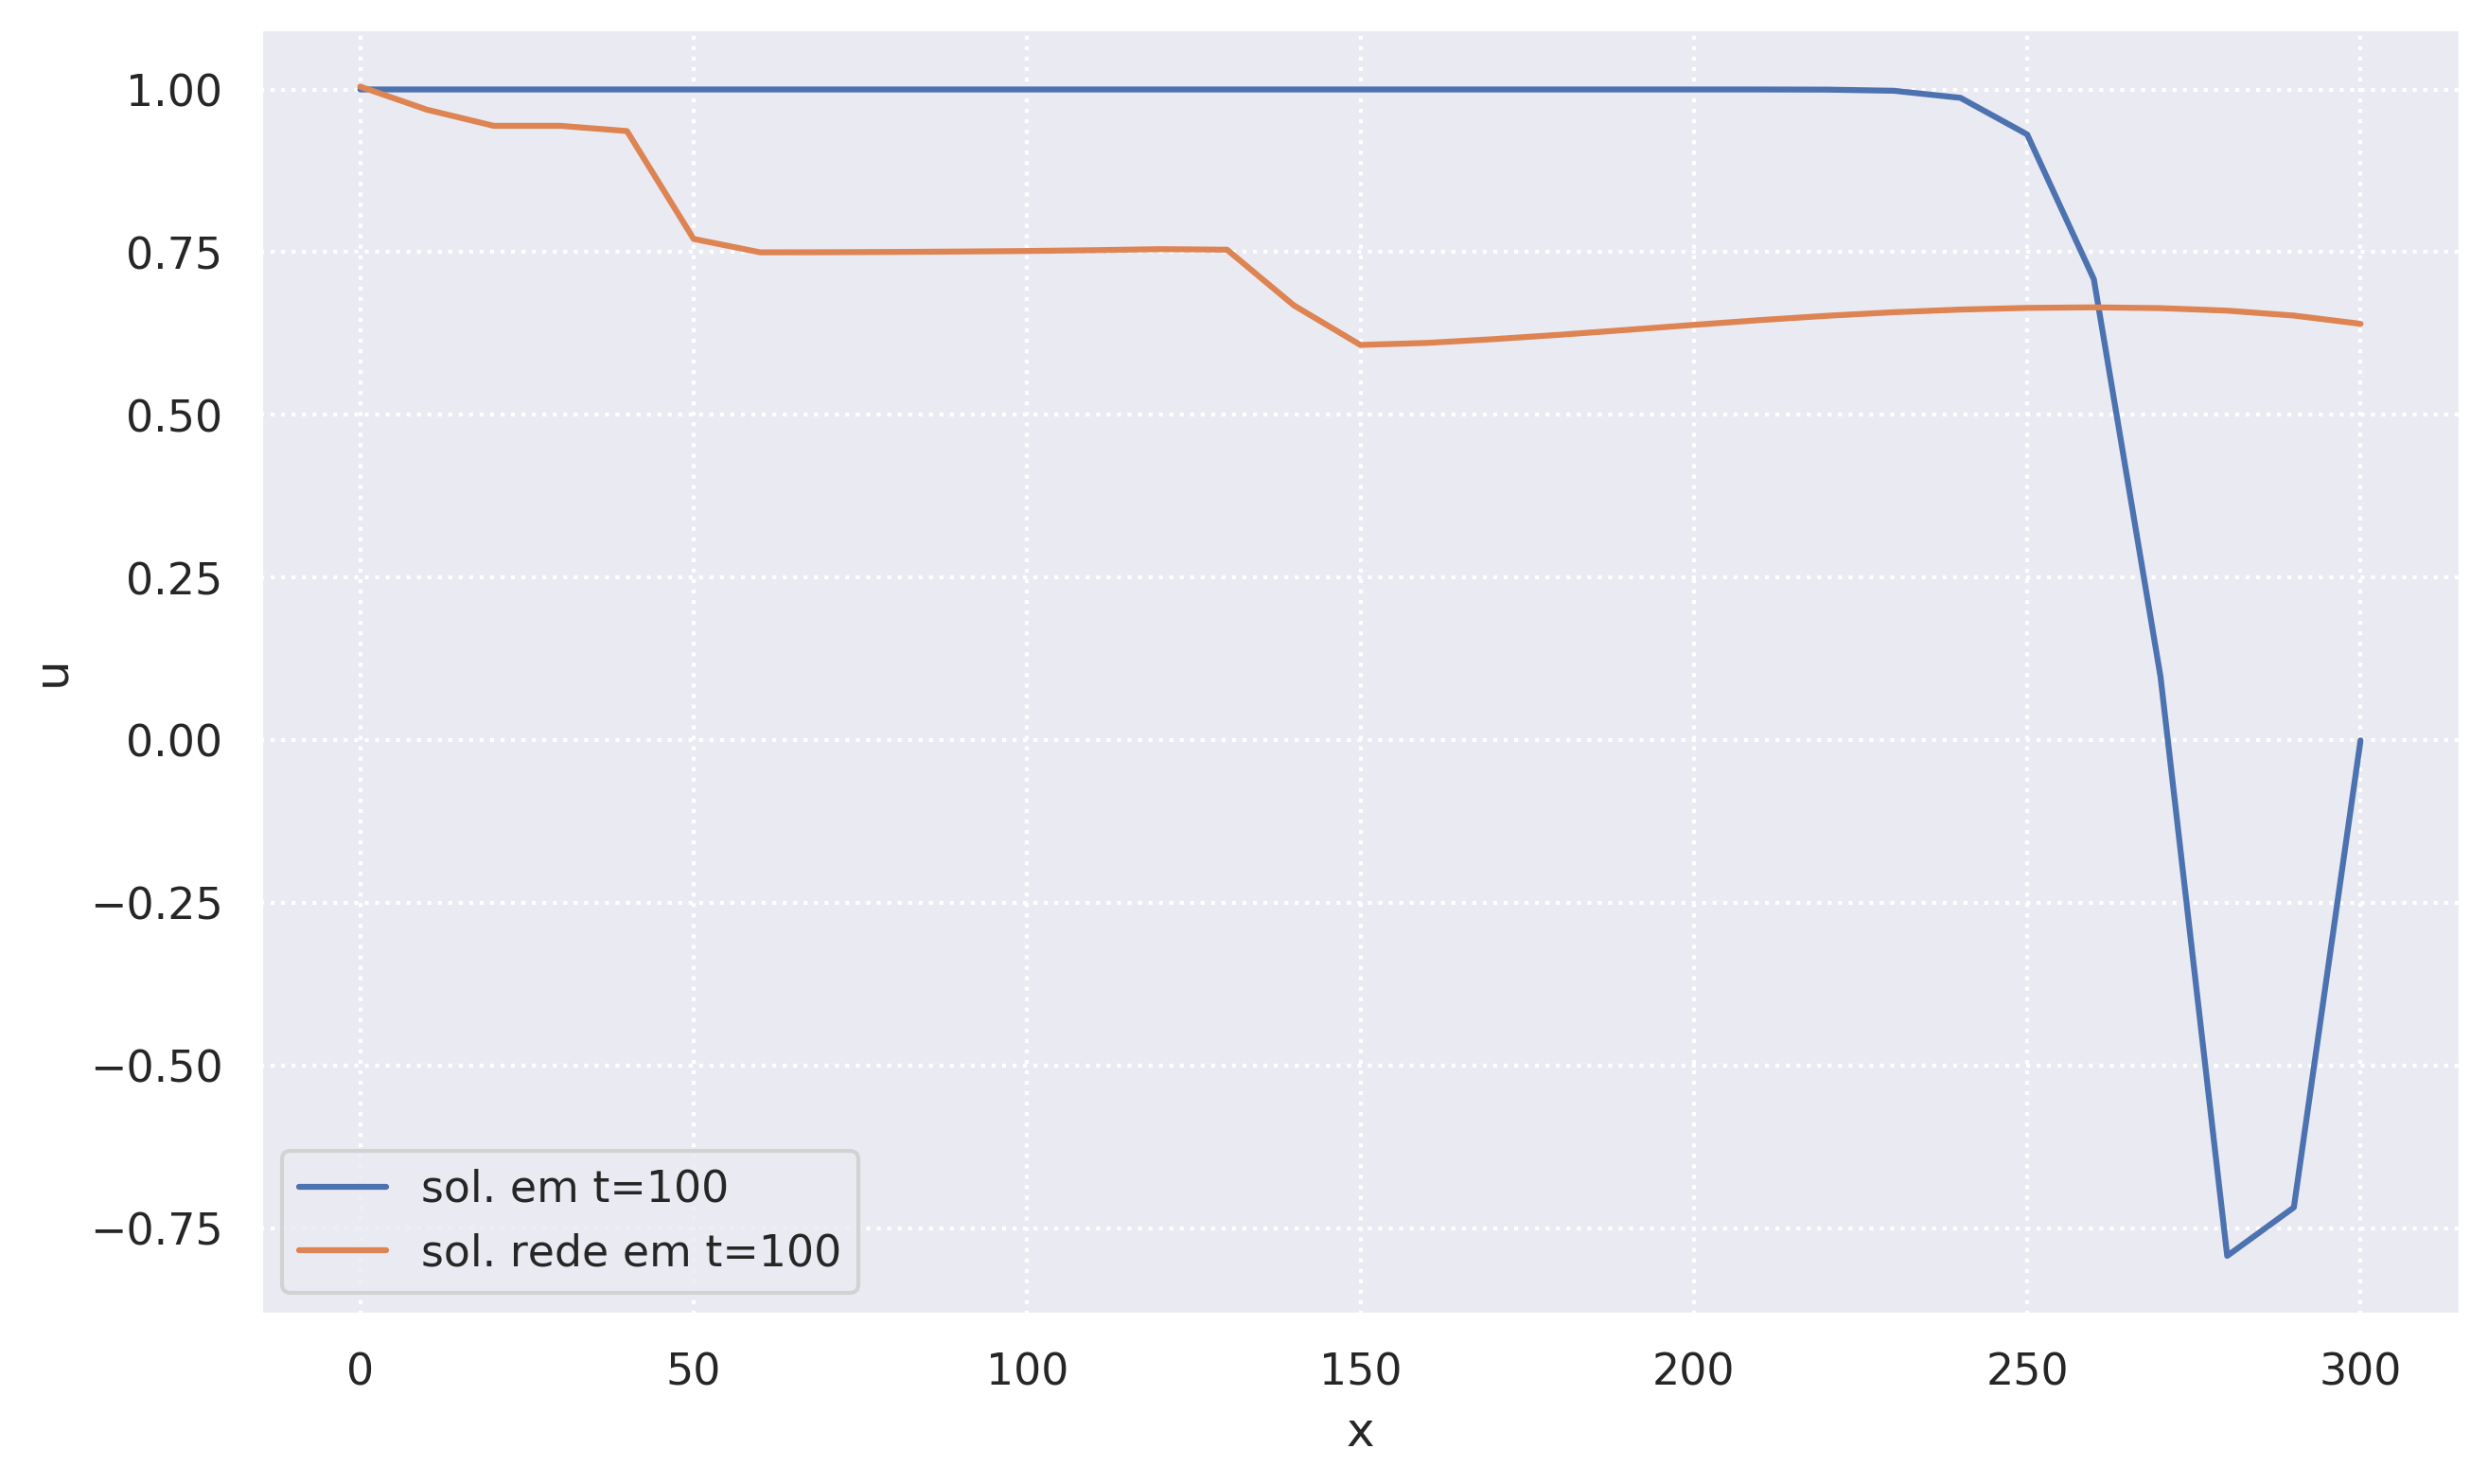

In [172]:
x_f=np.linspace(LCD1D.a,LCD1D.b,LCD1D.N).reshape(-1,1)
t_f = np.broadcast_to(np.array([T]),(N,1)).reshape((-1, 1))

plt.figure(figsize=(10,6), dpi=300)
plt.ylabel('u')
plt.xlabel('x')

plt.plot(x_f,nu,label="sol. em t="+str(T))
plt.legend()

plt.plot(x_f, u(params, x_f, t_f),label="sol. rede em t="+str(T))
plt.legend()
plt.grid(linestyle='dotted')